# Introduction to experimental design and data analysis in fMRI

In this lesson we will learn the very basics of experimental design in fMRI and also you'll have the chance to analyse data from one or two subjects in order to extract brain activation patterns.

This is done via a [Jupyter notebook](https://jupyter.org/) running an [Octave kernel](https://github.com/Calysto/octave_kernel) on [Binder](https://mybinder.org/), which allows cloud-based computation using SPM12 and Matlab scripts. It is therefore a reproducible environment for fMRI analysis using [SPM12](https://www.fil.ion.ucl.ac.uk/spm/software/download/). Anyone with internet access can run this same code on the same data and should get the same results. Besides being a useful tool for tutorials, this environment allows sharing work with collaborators and, maybe most importantly, represents a tool to share the data and methods underlying your scientific results.

In order to illustrate how we design and analyse data from an fMRI experiment, we will use data from from a non-VR study. Typically, VR-fMRI studies will first perform a VR experiment outside the scanner, with the hopes that that will elicit changes in how the brain functions that we can then detect using fMRI. The other approach, which is fortunately becoming more and more common, is to do a in-scanner VR study, where the equipment is MRI-compatible and won't be destroyed once you step a foot in. Then, you can scan **live** how your brain works when immersed in a virtual environment. 

These studies are still rare, and open, raw data isn't readily available to the public yet. This is why we will use scans from a non-VR study, but that can be easily thought as a real in-scanner VR study.

## How to use this notebook

First, we will explain briefly how [experiment design](#design) works in fMRI experiments through as simple paradigm where subjects see food and non-food images. Then we will overview a "typical" data [preprocessing pipeline](#preprocessing), going from the raw data acquired on the scanner all the way to the identification of common pattern of activation between two subjects, using the appropiate [statistical analysis](#stats). 

The output of each code cell is already available. This was done since the whole preprocessing pipeline takes around 50 minutes to complete, with some of the steps taking quite a while. Nevertheless, you are free to re-run it, change some parameters or even write more efficient code (I wish I was more proficient!). You could, for example, click on Run --> Run All Cells and let the notebook do its magic while we advance through this lesson. 

If at some point the kernel dies or it just stops working you can always go Kernel --> Restart Kernel. Worst case scenario would be to relaunch this instance again. 

Also, any cell can be collapsed (and expanded) if you click on the blue bar that appears to the left (some cells will print a very extense output, so it helps keeping the notebook "clean").

<a name="design">
</a>

## 1) Experimental design

### The experiment

For this tutorial we will use an open dataset from [OpenNeuro](https://www.openneuro.org), a data repository where you can find hundreds of raw neuroimaging (fMRI, MEG, EEG) datasets, standardized with [BIDS](https://bids.neuroimaging.io/) and freely available to anyone with an account. You can find the article to the study [here](https://www.ncbi.nlm.nih.gov/pubmed/23578759).

The authors were interested on wheter images of palatable food (chocolate, candy, etc.) evoked a brain response from visual areas and areas associated with self-regulation (a mechanism that would inhibit indulgence). Technicalities aside, the experimental paradigm was quite simple: inside the MRI scanner, subjects underwent a **task-based** experiment design where alternating **blocks** of visual stimuli containing either "food" images or "non-food" where shown to them, along with rest periods in between.

<center>
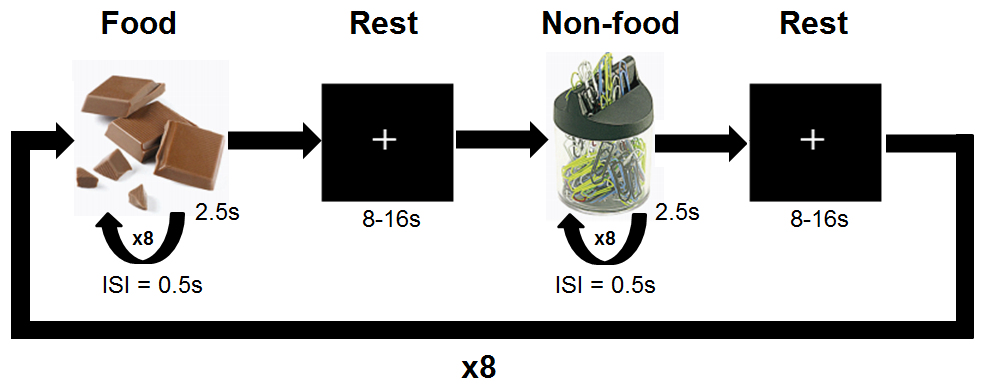
</center>

Here we see that the sequence Food->Rest->Non-Food->Rest is repeated 8 times over the course of the experiment, and that each food/non-food block consists of 8 different images, shown for 2.5 seconds with a inter-stimulus interval (ISI) of 0.5 seconds.

### Some basic concepts

There are a couple of term that might be worth explaining. A **task-based** design is one where subjects are expected to perform a certain action in response to the stimulus that is presented: watch, listen, read, move, think, imagine... This allows the identification of brain regions that are functionally involved in a specific task performance. On the other hand, there is the **resting-state** design, where subjects are supposed to do nothing (whatever that is) while they're being scanned. This method is employed whenever the researcher is interested in the spontaneus patters of brain activity and the compared them over time (i.e. after cognitive training) or between populations (i.e. young vs. old subjects). 

In our experiment, subjects were asked to watch the images, hoping that the content of the images (delicious chocolate vs. a pencil) would activate areas associated with complex visual stimuli and self-regulation (occipital cortex, basal ganglia, amygdala).

And to do that, we would *theoretically* need to "substract" the activation associated with food images from that of non-food images. That way, the resulting activation pattern (again, *theoritically*) would belong to *what makes the act of watching food different from watching other things (like its palatability or the need to self-regulate)*. 

And this is exactly what we are going to do with out data!

<a name="preprocessing">
</a>

## 2) Preprocessing pipeline

Once data collection is finished, the first aproach towards the analysis of fMRI data consists on a series of preprocessing steps. In short, preprocessing aims to get rid of unwanted fluctuations in the signal, both within and between subjects, in order to improve the signal-to-noise ratio.

There several sources of unwanted fluctuations or noise: head movements (and from other body parts as well), heartbeat, respiration and random drifts, to name the most common ones. 

So, throughout the following section we'll review some of the most important steps included in most preprocessing pipelines (beware that this tutorial is not a comprehensive tool to analyze any fMRI dataset, fine-tuning might be required).

### STEP 0: Getting your data ready

This notebook will enable you to do a complete round of preprocessing and statistical analysis of 1 or 2 subjects' raw data, right from the MRI scanner. The initial dataset of each subject consists of the following:

- 1 anatomical volume: This is a high resolution image of the brain, which will be used as a reference to the other images.
- 170 functional volumes: These are T2* (tee-two-star) weighted images, which refers to a different acqusition protocol which best captures small changes in brain tissue oxygenation (more on this, later).
- 1 event file: Includes relevant time information about when were the stimuli shown to the subject (**onsets**) and for how long (**durations**).

You can find these files if you navigate the folder `ds000157-download` which can be found in the file explorer to the left.

Now, what steps are involved in a (minimal) preprocessing pipeline? This diagram might give you an idea:

<center>
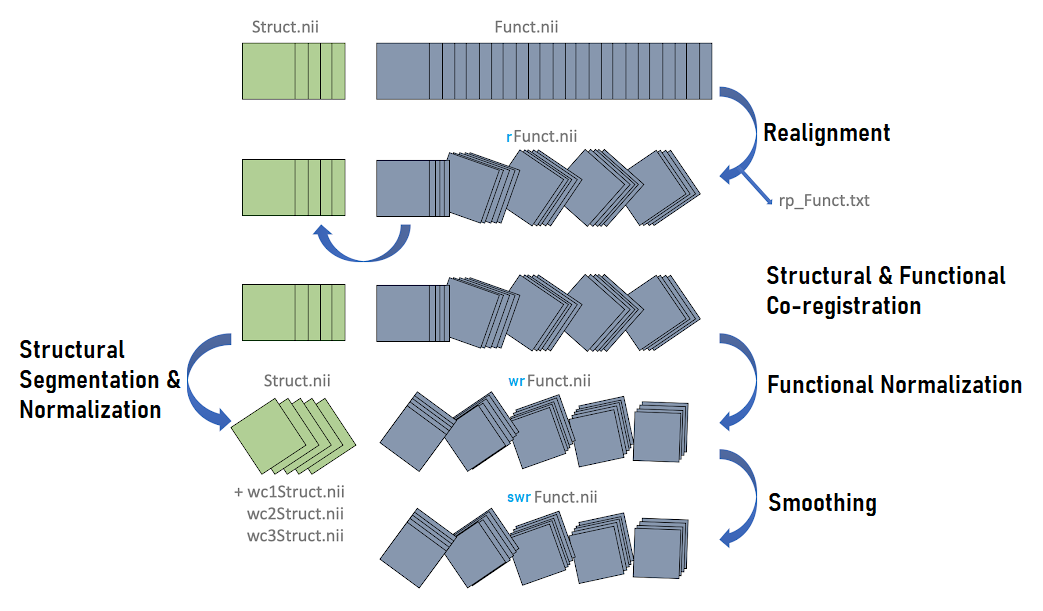
</center>

We can see that structural and functional images follow separate as well as mutual preprocessing steps. Also, note that after each step a new file is written, including a prefix in its name (r, w, s) which is more or less standardized in the field, and indicates in what preprocessing stage that volume currently is.

With this in mind, run the code below in order to extract the required image files, move them to the correct preprocessing folders, setup the desired directory structure, and initialize all required variables. Wait until the output prints "Done".

In [1]:
% Preprocessed and analysed data will be in "results/" folder
data_dir = fullfile(getenv('HOME'),'ds000157-download');
spm_dir = fullfile(getenv('HOME'),'spm12');
preproc_dir = fullfile(getenv('HOME'),'preproc_data');
results_dir = fullfile(getenv('HOME'),'results');
stats_dir = [results_dir filesep 'stats'];
processing_dir = [results_dir filesep 'preproc_data'];
if ~exist(stats_dir,'dir')
    mkdir(stats_dir);
end
if ~exist(processing_dir,'dir')
    mkdir(processing_dir);
end

% Initialize subject data; extract; copy to preprocessing folder

% count subjects in folder; can be expanded if downloaded more
dir_sub = dir(data_dir);
n_sub = length(dir_sub) - 2;

func_files = cell(n_sub,1);
anat_files = cell(n_sub,1);

for i = 1:n_sub
    if i < 10
        sub_path = '0%d';
        sub = sprintf(sub_path, i);
    else
        sub = i;
    end

    s_raw_fn = fullfile(data_dir, ['sub-' sub], 'anat', ['sub-' sub '_T1w.nii.gz']);
    if exist(s_raw_fn, 'file')
        out_fns = gunzip(s_raw_fn);
        s_fn = out_fns{1};
    else
        s_fn = strrep(s_raw_fn, '.gz', '');
    end
    f_raw_fn = fullfile(data_dir, ['sub-' sub], 'func', ['sub-' sub '_task-passiveimageviewing_bold.nii.gz']);
    if exist(f_raw_fn, 'file')
        out_fns = gunzip(f_raw_fn);
        f_fn = out_fns{1};
    else
        f_fn = strrep(f_raw_fn, '.gz', '');
    end

    % Create preprocessing subfolders
    anat_dir = fullfile(processing_dir, ['sub-' sub], 'anat'); 
    func_dir = fullfile(processing_dir, ['sub-' sub], 'func'); 
    stats_dir = fullfile(processing_dir, ['sub-' sub], 'stats');
    if ~exist(anat_dir, 'dir')
        mkdir(anat_dir);
    end
    if ~exist(func_dir, 'dir')
        mkdir(func_dir);
    end
    if ~exist(stats_dir, 'dir')
        mkdir(stats_dir);
    end
    
    % Copy extracted files to preprocessing subfolders
    anat_fn = fullfile(processing_dir, ['sub-' sub], 'anat', ['sub-' sub '_T1w.nii']);
    anat_files(i,1) = anat_fn; 
    func_fn = fullfile(processing_dir, ['sub-' sub], 'func', ['sub-' sub '_task-passiveimageviewing_bold.nii']);
    func_files(i,1) = func_fn; 
    if ~exist(anat_fn, 'file')
        copyfile(s_fn, anat_dir);
    end
    if ~exist(func_fn, 'file')
        copyfile(f_fn, func_dir);
    end
end
    % Initialize processing variables
fwhm = 6;  % mm
disp('Done')

Done


Before actually starting preprocessing, it is good practice to manually inspect the images. You should look for gross displacement, signal alterations or even brain abnormalities (which might be a exclusion criteria). 

Since this notebook's setup doesn't allow for any fancy command-line image visualization, what we will do instead is print coronal, axial and sagital cuts of our subjects' structural and functional images, which should be enough for us to notice if there something really wrong with our data. Notice how brains already differ between subjects.

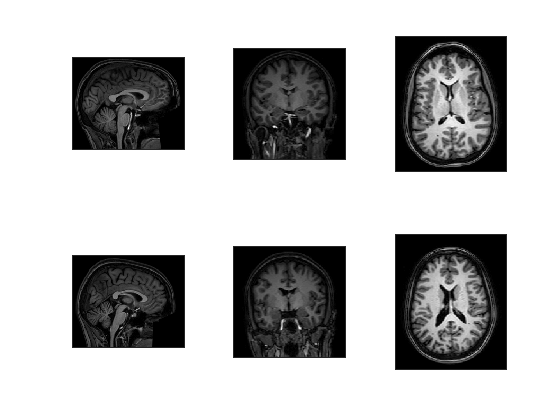

In [2]:
%% QUICK INSPECTION OF ANATOMICAL DATA
% Sub-01
[p_anat, frm1, rg1, dim1] = fmrwhy_util_readNifti(char(anat_files(1,1)));
anat_3Dimg = p_anat.nii.img;

[Ni, Nj, Nk] = size(anat_3Dimg);
subplot(231); imagesc(rot90(squeeze(anat_3Dimg(round(Ni/2),35:245,1:Nk/2+30)))); colormap gray; axis image; set(gca,'xtick',[],'ytick',[]);
subplot(232); imagesc(rot90(squeeze(anat_3Dimg(:,round(Nj/2),1:Nk/2+30)))); colormap gray; axis image; set(gca,'xtick',[],'ytick',[]);
subplot(233); imagesc(rot90(squeeze(anat_3Dimg(:,35:245,round(Nk*0.35))))); colormap gray; axis image; set(gca,'xtick',[],'ytick',[]);

% Sub-02
[p_anat, frm1, rg1, dim1] = fmrwhy_util_readNifti(char(anat_files(2,1)));
anat_3Dimg = p_anat.nii.img;

[Ni, Nj, Nk] = size(anat_3Dimg);
subplot(234); imagesc(rot90(squeeze(anat_3Dimg(round(Ni/2),35:245,1:Nk/2+30)))); colormap gray; axis image; set(gca,'xtick',[],'ytick',[]);
subplot(235); imagesc(rot90(squeeze(anat_3Dimg(:,round(Nj/2),1:Nk/2+30)))); colormap gray; axis image; set(gca,'xtick',[],'ytick',[]);
subplot(236); imagesc(rot90(squeeze(anat_3Dimg(:,35:245,round(Nk*0.35))))); colormap gray; axis image; set(gca,'xtick',[],'ytick',[]);

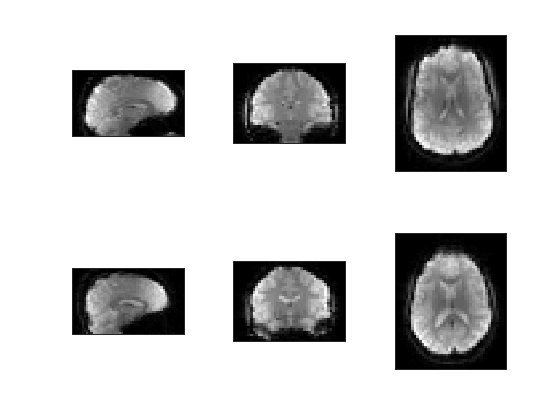

In [3]:
%% QUICK INSPECTION OF FUNCTIONAL DATA
% Sub-01
[p_func, frm1, rg1, dim1] = fmrwhy_util_readNifti(char(func_files(1,1)));
func_4Dimg = p_func.nii.img;

[Ni, Nj, Nk, Nt] = size(func_4Dimg);
subplot(231); imagesc(rot90(squeeze(func_4Dimg(round(Ni/2),8:58,:,1)))); colormap gray; axis image; set(gca,'xtick',[],'ytick',[]);
subplot(232); imagesc(rot90(squeeze(func_4Dimg(12:53,round(Nj/2),:,1)))); colormap gray; axis image; set(gca,'xtick',[],'ytick',[]);
subplot(233); imagesc(rot90(squeeze(func_4Dimg(12:53,8:58,round(Nk/2),1)))); colormap gray; axis image; set(gca,'xtick',[],'ytick',[]);

% Sub-02 
[p_func, frm1, rg1, dim1] = fmrwhy_util_readNifti(char(func_files(2,1)));
func_4Dimg = p_func.nii.img;

[Ni, Nj, Nk, Nt] = size(func_4Dimg);
subplot(234); imagesc(rot90(squeeze(func_4Dimg(round(Ni/2),8:58,:,1)))); colormap gray; axis image; set(gca,'xtick',[],'ytick',[]);
subplot(235); imagesc(rot90(squeeze(func_4Dimg(12:53,round(Nj/2),:,1)))); colormap gray; axis image; set(gca,'xtick',[],'ytick',[]);
subplot(236); imagesc(rot90(squeeze(func_4Dimg(12:53,8:58,round(Nk/2),1)))); colormap gray; axis image; set(gca,'xtick',[],'ytick',[]);

We'll take this chance to compare how structural and functional images differ from one to another. Run the next cell. 

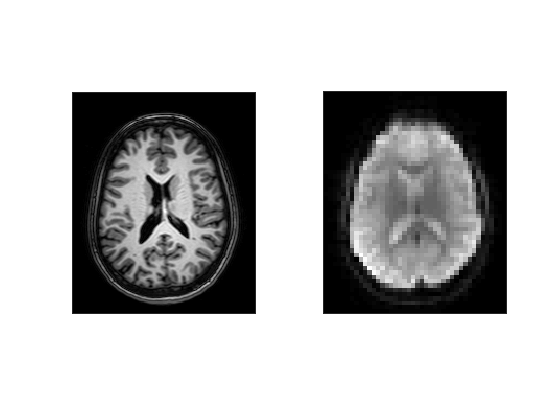

In [4]:
% Comparing Sub-01 anatomical and functional volumes

% Sub-02 anatomical
[Ni, Nj, Nk] = size(anat_3Dimg);
subplot(121); imagesc(rot90(anat_3Dimg(:,35:245,round(Nk*0.35)))); colormap gray; axis image; set(gca,'xtick',[],'ytick',[]); 

% Sub-02 functional
[Ni, Nj, Nk, Nt] = size(func_4Dimg);
subplot(122); imagesc(rot90(func_4Dimg(12:53,8:58,round(Nk/2),1))); colormap gray; axis image; set(gca,'xtick',[],'ytick',[]); 

Notice how the structual image (on the left) clearly shows many encephalic structures (the gray matter in the cortex, inner white matter, the ventricles). Its voxel resolution is 1mm<sup>3</sup>, so some level of detail is to be expected.

Conversely, the functional image (on the right) looks quite grainy and the contrast look somehow inverted. This is explained by the volume's lower resolution (2.5mm<sup>3</sup>) and the fact that it is a T2*-weighted scan. Explaining MRI sequences is beyond the scope of this lesson (you can read more about them [here](http://mri-q.com/t2-vs-t2.html)), but just consider that this sequence is the best we have to measure small changes in **deoxygenated hemoglobin** (the blood protein that carries oxygen), which is what we assume happens when some part of the brain gets activated. This results in some signal intensity variations that we call the **BOLD (Blood Oxygen Level Dependent) contrast**

But what are we trying to measure? BOLD-fMRI signal fluctuations can be detected on a voxel-level if we take enough samples. On the next cell you can see how that signal behaves across time in a single voxel (you can change its coordinates and see how (if) it changes.

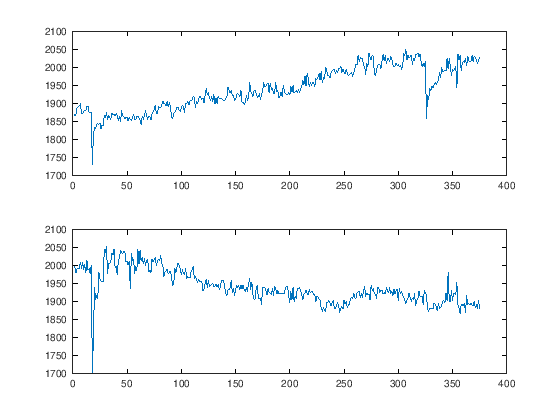

In [19]:
% BOLD-timeseries of a random voxel from V1 (primary visual cortex) vs. random voxel from AC (anterior cingulate cortex)

[Ni, Nj, Nk, Nt] = size(func_4Dimg);
subplot(211); plot(func_4Dimg(37,15,round(Nk/2),:))
subplot(212); plot(func_4Dimg(Ni/2,47,round(Nk/2),:))

In the example above, you can see how the signal goes different ways between regions (signal from the primary visual cortex voxel increases over time, whereas that of the anterior cingulate voxel decreases over time).

### STEP 1: Realignment

Once we visually inspected or data and made sure there weren't any problems, we are finally ready to start our preprocessing pipeline. The first step is called **realigment** or motion correction of functional images, which tries to take care of the main source of the largest source of noise in fMRI which is head movement. From a starting volume of reference, it measures three directions of displacement (x, y, z) and three axes of rotation (raw, pitch, yaw) and registers how they change over the course of the experiment with each functional volume that is acquired. 

Running the following cell will realign each subject's functional volumes and create a `.txt` file that included the 6 motion parameters of each of the 170 volumes. 

In [7]:
% Realign all subjects (correct script name)
preproc_data = struct;
for k = 1:n_sub
    preproc_data(k) = spm_realign_ler(char(func_files(k,1)), char(anat_files(k,1)), fwhm, spm_dir);
end

Step 1 -- Realign all volumes to first functional volume


------------------------------------------------------------------------
24-Mar-2021 22:42:52 - Running job #1
------------------------------------------------------------------------
24-Mar-2021 22:42:52 - Running 'Realign: Estimate & Reslice'

SPM12: spm_realign (v7141)                         22:42:52 - 24/03/2021
Completed                               :          22:44:16 - 24/03/2021

SPM12: spm_reslice (v7141)                         22:44:16 - 24/03/2021
Completed                               :          22:45:04 - 24/03/2021
24-Mar-2021 22:45:05 - Done    'Realign: Estimate & Reslice'
24-Mar-2021 22:45:05 - Done

Step 1 - Done!
Step 1 -- Realign all volumes to first functional volume


------------------------------------------------------------------------
24-Mar-2021 22:45:21 - Running job #1
------------------------------------------------------------------------
24-Mar-2021 22:45:21 - Running 'Realign: Estimate & Re

In healthy and younger populations there is little movement that needs to be corrected for. It usually becomes a problem with children or in patients with certain conditions (Parkinson's disease or other sources of tremors). Since movements revolves around a few milimiters in either direction, visually inspecting how volumes are displaced is quite hard. Fortunately, if we just plot those motion parameters over time, we'll get a better glance of how much that subject moved during that session.

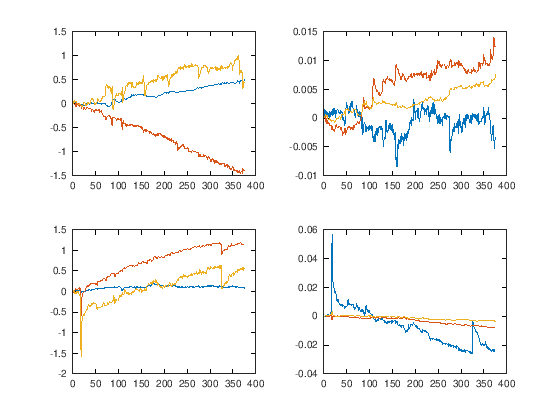

In [8]:
% Plot motion parameters (left column = displacement parameters; right colums = axes of rotation)

% Sub-01 motion parameters
m_par = preproc_data(1).mp_fn;
motion = load(m_par);
subplot(221); plot(motion(:,1:3)) % rotational x,y,z
subplot(222); plot(motion(:,4:6)) % traslational raw, pitch, yaw

% Sub-02 motion parameters
m_par = preproc_data(2).mp_fn;
motion = load(m_par);
subplot(223); plot(motion(:,1:3)) % rotational x,y,z
subplot(224); plot(motion(:,4:6)) % traslational raw, pitch, yaw


As we can see, subjects almost didn't move at all (other that a couple milimiters or small fraction of a radian). Notice, though, that Sub-02 data shows a couple of spikes of movement. This might become important later on.

### STEP 2: Structural and functional co-registration

Next, we will bring both the structural and functional images to the same space in a process called **co-registration**. It basically just aligns and overlays each subject's functional images with its corresponding structural image. The purpose of this step is that brain activations detected in the functional data are mapped as accurately as possible to its corresponding anatomical structures.

In [9]:
% Co-register anatomical and functional 
for k = 1:n_sub
    spm_coregister_ler(char(func_files(k,1)), char(anat_files(k,1)), fwhm, spm_dir);
end

Step 2 -- Coregister structural image to first dynamic image


------------------------------------------------------------------------
24-Mar-2021 22:47:56 - Running job #1
------------------------------------------------------------------------
24-Mar-2021 22:47:56 - Running 'Coregister: Estimate'

SPM12: spm_coreg (v7320)                           22:47:56 - 24/03/2021
Completed                               :          22:48:13 - 24/03/2021
24-Mar-2021 22:48:13 - Done    'Coregister: Estimate'
24-Mar-2021 22:48:13 - Done

Step 2 - Done!
Step 2 -- Coregister structural image to first dynamic image


------------------------------------------------------------------------
24-Mar-2021 22:48:28 - Running job #1
------------------------------------------------------------------------
24-Mar-2021 22:48:28 - Running 'Coregister: Estimate'

SPM12: spm_coreg (v7320)                           22:48:28 - 24/03/2021
Completed                               :          22:48:47 - 24/03/2021
24-Mar

### STEP 3: Segmentation

When we scan someone's head we don't only acquire an image of his/her brain; other tissues, such as bone, fat or even the eyes are part of that image. Since we will be looking exclusively at neural tissue (namely the gray matter and white matter) it makes sense to try and get rid of those other structures that we're not interested in. 

In this structural-exclusive step, we will separate or **segment** the anatomical image into its 6 tissue types: gray matter (GM), white matter (WM), cerebrospinal fluid (CSF), bone, soft tissue and air. Not all of them are necessary (GM, WM and CSF are usually enough), but we will segment all of them to better illustrate how the algorithm very accurately picks each of them.

In [10]:
% Segment anatomical 
for k = 1:n_sub
    spm_segmentation_ler(char(func_files(k,1)), char(anat_files(k,1)), fwhm, spm_dir);
    [d, f, e] = fileparts(char(anat_files(k,1)));
    preproc_data(k).forward_transformation = [d filesep 'y_' f e];
    preproc_data(k).inverse_transformation = [d filesep 'iy_' f e];
    preproc_data(k).gm_fn = [d filesep 'c1' f e];
    preproc_data(k).wm_fn = [d filesep 'c2' f e];
    preproc_data(k).csf_fn = [d filesep 'c3' f e];
    preproc_data(k).bone_fn = [d filesep 'c4' f e];
    preproc_data(k).soft_fn = [d filesep 'c5' f e];
    preproc_data(k).air_fn = [d filesep 'c6' f e];
end

% Reslice
for k = 1:n_sub
    spm_reslice_ler(char(func_files(k,1)), char(anat_files(k,1)), fwhm, spm_dir);
    [d, f, e] = fileparts(char(anat_files(k,1)));
    preproc_data(k).rstructural_fn = [d filesep 'r' f e];
    preproc_data(k).rgm_fn = [d filesep 'rc1' f e];
    preproc_data(k).rwm_fn = [d filesep 'rc2' f e];
    preproc_data(k).rcsf_fn = [d filesep 'rc3' f e];
    preproc_data(k).rbone_fn = [d filesep 'rc4' f e];
    preproc_data(k).rsoft_fn = [d filesep 'rc5' f e];
    preproc_data(k).rair_fn = [d filesep 'rc6' f e];
end

Step 3 -- Segmentation


------------------------------------------------------------------------
24-Mar-2021 22:49:04 - Running job #1
------------------------------------------------------------------------
24-Mar-2021 22:49:04 - Running 'Segment'

SPM12: spm_preproc_run (v7670)                     22:49:04 - 24/03/2021
Segment /home/jovyan/results/preproc_data/sub-01/anat/sub-01_T1w.nii
Completed                               :          22:56:15 - 24/03/2021
24-Mar-2021 22:56:15 - Done    'Segment'
24-Mar-2021 22:56:15 - Done

Step 3 - done!
Step 3 -- Segmentation


------------------------------------------------------------------------
24-Mar-2021 22:56:32 - Running job #1
------------------------------------------------------------------------
24-Mar-2021 22:56:33 - Running 'Segment'

SPM12: spm_preproc_run (v7670)                     22:56:33 - 24/03/2021
Segment /home/jovyan/results/preproc_data/sub-02/anat/sub-02_T1w.nii
Completed                               :          23:03

Once this long step is done (it should take between 15-20 minutes for both subjects), run this next cell to visualize all Sub-01's segmented tissues. The order of presentation is as follows: GM-WM-CSF-Bone-Soft tissue-Air

You can try to change to Sub-02 segmentations and see how its tissue anatomy changes.

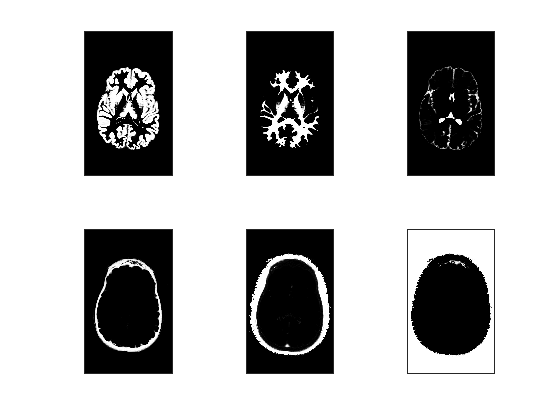

In [11]:
% Visualize tissue images

c1_fn = spm_vol(preproc_data(1).gm_fn);
c1 = spm_read_vols(c1_fn);
[Ni, Nj, Nk] = size(c1);
subplot(231); imagesc(rot90(squeeze(c1(:,:,round(Nk/3),1)))); colormap gray; axis image; set(gca,'xtick',[],'ytick',[]);

c2_fn = spm_vol(preproc_data(1).wm_fn);
c2 = spm_read_vols(c2_fn);
[Ni, Nj, Nk] = size(c2);
subplot(232); imagesc(rot90(squeeze(c2(:,:,round(Nk/3),1)))); colormap gray; axis image; set(gca,'xtick',[],'ytick',[]);

c3_fn = spm_vol(preproc_data(1).csf_fn);
c3 = spm_read_vols(c3_fn);
[Ni, Nj, Nk] = size(c3);
subplot(233); imagesc(rot90(squeeze(c3(:,:,round(Nk/3),1)))); colormap gray; axis image; set(gca,'xtick',[],'ytick',[]);

c4_fn = spm_vol(preproc_data(1).bone_fn);
c4 = spm_read_vols(c4_fn);
[Ni, Nj, Nk] = size(c4);
subplot(234); imagesc(rot90(squeeze(c4(:,:,round(Nk/3),1)))); colormap gray; axis image; set(gca,'xtick',[],'ytick',[]);

c5_fn = spm_vol(preproc_data(1).soft_fn);
c5 = spm_read_vols(c5_fn);
[Ni, Nj, Nk] = size(c5);
subplot(235); imagesc(rot90(squeeze(c5(:,:,round(Nk/3),1)))); colormap gray; axis image; set(gca,'xtick',[],'ytick',[]);

c6_fn = spm_vol(preproc_data(1).air_fn);
c6 = spm_read_vols(c6_fn);
[Ni, Nj, Nk] = size(c6);
subplot(236); imagesc(rot90(squeeze(c6(:,:,round(Nk/3),1)))); colormap gray; axis image; set(gca,'xtick',[],'ytick',[]);

### STEP 4: Normalization

It is known that not all brains are equal, just as intracraneal volume or body size aren't either. If we are thinking of running a study with several participants, how do we make sure that all those brains are comparable between each other? Since obtaining exactly equal brains is impossible, the next big thing we have is to try approximate or **normalize** their dimensions to a common reference template. 

Two of the most used templates are the MNI (Montreal Neurological Institute) or the Talairach templates which are made out of hundreds of young, healthy brains. This sort of standardization also helps scientists to share and compare their results, since we would all have the same topological coordinate systems. 

In [13]:
% Normalize
for k = 1:n_sub
    spm_normalize_ler(char(func_files(k,1)), char(anat_files(k,1)), fwhm, spm_dir, preproc_data(k));
    [d1, f1, e1] = fileparts(preproc_data(k).rfunctional_fn);
    preproc_data(k).wrfunctional_fn = [d1 filesep 'w' f1 e1];
end

Step 5 -- Normalize (estimate and reslice) functionals to MNI


------------------------------------------------------------------------
24-Mar-2021 23:04:54 - Running job #1
------------------------------------------------------------------------
24-Mar-2021 23:04:54 - Running 'Normalise: Estimate & Write'

SPM12: spm_preproc_run (v7670)                     23:04:54 - 24/03/2021
Segment /home/jovyan/results/preproc_data/sub-01/anat/rsub-01_T1w.nii
Completed                               :          23:06:53 - 24/03/2021
24-Mar-2021 23:08:42 - Done    'Normalise: Estimate & Write'
24-Mar-2021 23:08:42 - Done

Step 5 - Done!
Step 5 -- Normalize (estimate and reslice) functionals to MNI


------------------------------------------------------------------------
24-Mar-2021 23:08:59 - Running job #1
------------------------------------------------------------------------
24-Mar-2021 23:09:00 - Running 'Normalise: Estimate & Write'

SPM12: spm_preproc_run (v7670)                     23:09:00

Since we are **normalizaing** our subjects functional images, we would expect a change in appearance, concretely to one that more closely resembles the template that was used. To compare the previously realigned imaged to a normalized one, run the next cell.

On the left you will see the normalized image. 

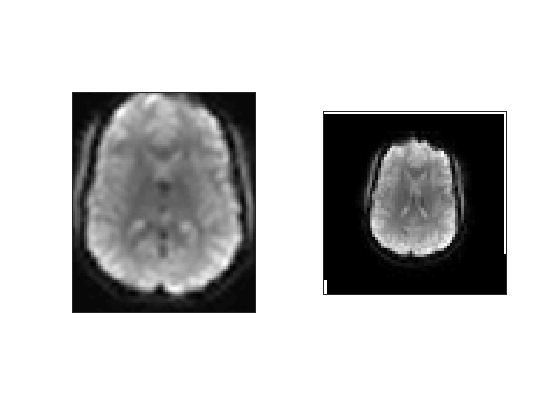

In [14]:
% Visualize normalized functional image

norm_fn = spm_vol(fullfile(processing_dir, 'sub-01', 'func', 'wrsub-01_task-passiveimageviewing_bold.nii,1'));
norm_func = spm_read_vols(norm_fn);
[Ni, Nj, Nk] = size(norm_func);
subplot(121); imagesc(rot90(squeeze(norm_func(:,:,round(Nk/2))))); colormap gray; axis image; set(gca,'xtick',[],'ytick',[]);

non_norm_fn = spm_vol(fullfile(processing_dir, 'sub-01', 'func', 'rsub-01_task-passiveimageviewing_bold.nii,1'));
non_norm_func = spm_read_vols(non_norm_fn);
[Ni, Nj, Nk] = size(non_norm_func);
subplot(122); imagesc(rot90(squeeze(non_norm_func(:,:,round(Nk/2))))); colormap gray; axis image; set(gca,'xtick',[],'ytick',[]);
subplot(122); imagesc(rot90(squeeze(non_norm_func(12:53,8:58,round(Nk/2),1))); colormap gray; axis image; set(gca,'xtick',[],'ytick',[]);


### STEP 5: Smoothing

So far we have taken care of some of the sources of noise in our data (head movement), extracted the tissues we're interested in out of the structural image, registrated each subject's own functional and structural images and brought all of them to a common space so that they can be compared with each other and with other studies. 

Despite all of this, this whole process isn't perfect, and we're bound to still encounter with noise that may interfere when performing statistical analysis and therefore when making inferences about our findings, specially when many subjects are involved. One solution to this problem has been to **smooth** each voxel's signal by averaging it with that of its neighboring voxels. This usually leads to an increased signal-to-noise ratio, at the cost of spatial specificity. 

In [15]:
% Smooth
for k = 1:n_sub
    spm_smooth_ler(char(func_files(k,1)), char(anat_files(k,1)), fwhm, spm_dir, preproc_data(k));
    [d, f, e] = fileparts(preproc_data(k).wrfunctional_fn);
    preproc_data(k).swrfunctional_fn = [d filesep 's' f e];
end

Step 6 -- Gaussian kernel smoothing of realigned data


------------------------------------------------------------------------
24-Mar-2021 23:12:53 - Running job #1
------------------------------------------------------------------------
24-Mar-2021 23:12:53 - Running 'Smooth'
24-Mar-2021 23:16:00 - Done    'Smooth'
24-Mar-2021 23:16:00 - Done

Step 6 - done!
Step 6 -- Gaussian kernel smoothing of realigned data


------------------------------------------------------------------------
24-Mar-2021 23:16:16 - Running job #1
------------------------------------------------------------------------
24-Mar-2021 23:16:16 - Running 'Smooth'
24-Mar-2021 23:18:54 - Done    'Smooth'
24-Mar-2021 23:18:54 - Done

Step 6 - done!


If we compare a normalized functional image against a smoothed one, you'll be able to notice the difference right away. If the activation effect we're looking for is robust enough, it will survive the smoothing and appear on posterior analyses.

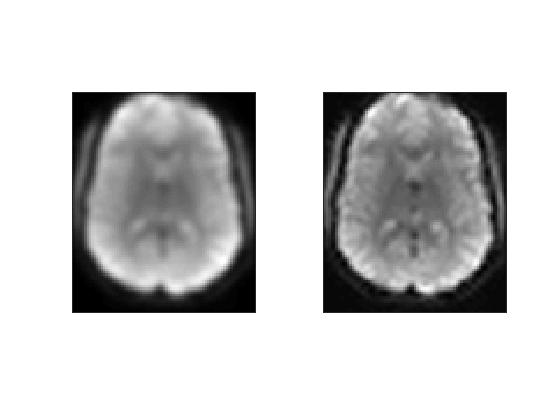

In [16]:
% Visualize smoothed functional image

sm_fn = spm_vol(fullfile(processing_dir, 'sub-01', 'func', 'swrsub-01_task-passiveimageviewing_bold.nii,1'));
smooth_func = spm_read_vols(sm_fn);
[Ni, Nj, Nk] = size(smooth_func);
subplot(121); imagesc(rot90(squeeze(smooth_func(:,:,round(Nk/2))))); colormap gray; axis image; set(gca,'xtick',[],'ytick',[]);

norm_fn = spm_vol(fullfile(processing_dir, 'sub-01', 'func', 'wrsub-01_task-passiveimageviewing_bold.nii,1'));
norm_func = spm_read_vols(norm_fn);
[Ni, Nj, Nk] = size(norm_func);
subplot(122); imagesc(rot90(squeeze(norm_func(:,:,round(Nk/2))))); colormap gray; axis image; set(gca,'xtick',[],'ytick',[]);

<a name="stats">
</a>

## 3) Statistical analysis

## STEP 4: Create 1st level statistical design

Here we create the first level statistical design to analyse the preprocessed data. This is done with `spm_specify1stlevel_jsh`.

We set the timing units as seconds because that is how we want to specify the task stimulus onsets and durations (the other unit option is ‘scans’). The repetition time is set to 1.6 seconds, as specified in the `task-passiveimageviewing_bold.json` file supplied together with the dataset. The task stimulus onsets and durations are given in the `sub-01_task-passiveimageviewing_events.tsv` file supplied with the `sub-01` data. The `.tsv` file also gives the type of stimulus, either food or non-food pictures. For this exercise, we are not interested in the differences in brain responses between food and non-food picture viewing, rather we just want to see which voxels in the brain are likely involved in any type of picture viewing experience vs only looking at a black screen with a cursor. This is why we specified vectors of all onset times and durations (except for the break period) for the respective parameters. Finally we also supply the text file with the movement parameters (`preproc_data.mp_fn`; resulting from the 6 DOF rigid body transformations during the realignment step) to be included as regressors in the design matrix.

Can not initialise pmod value(s): job is not a struct.
Can not initialise regress value(s): job is not a struct.
Can not initialise fact value(s): job is not a struct.


------------------------------------------------------------------------
24-Mar-2021 23:19:12 - Running job #1
------------------------------------------------------------------------
24-Mar-2021 23:19:12 - Running 'fMRI model specification'

SPM12: spm_fMRI_design (v7739)                     23:19:12 - 24/03/2021
Saving fMRI design                      :               ...SPM.mat saved

SPM12: spm_fmri_spm_ui (v7738)                     23:19:13 - 24/03/2021
Mapping files                           :                        ...done
Calculating globals                     :                        ...done
Saving SPM configuration                :               ...SPM.mat saved
Saving SPM configuration                :               ...SPM.mat saved
Completed                               :          23:19:23 - 24/03/2021
24

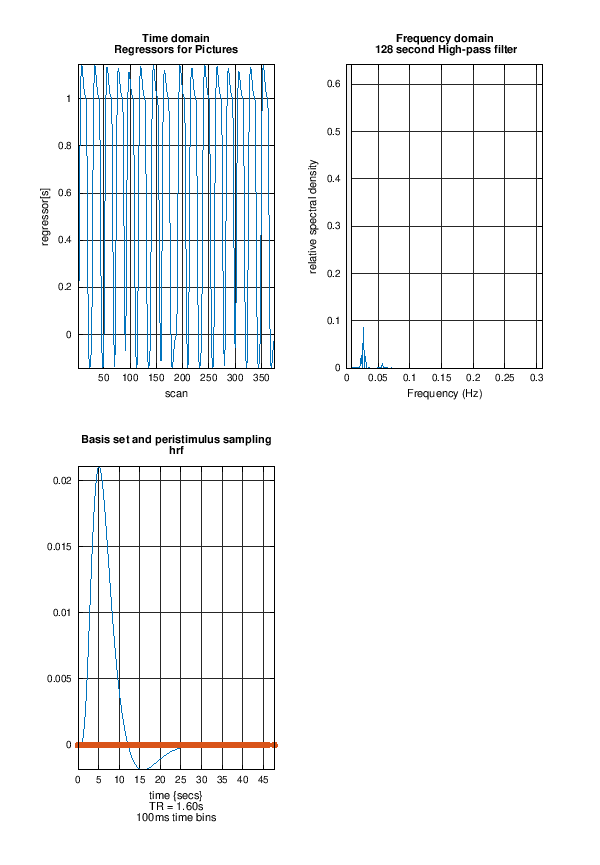

In [17]:
% Set up statistical design parameters, based on task data

    sess_params = struct;
    sess_params.timing_units = 'secs';
    sess_params.timing_RT = 1.6;
    sess_params.cond_name = 'Pictures';
    sess_params.cond_onset = [0; 40.1; 77.2; 111.3; 143.3; 179.4; 218.5; 251.5; 299.6; 334.7; 374.8; 411.9; 445.9; 478.0; 514.1; 553.2];
    sess_params.cond_duration = [24.1000; 24.06; 24.07; 24.06; 24.06; 24.07; 24.04; 24.06; 24.07; 24.10; 24.06; 24.06; 24.09; 24.09; 24.06; 24.07];
    
for i = 1:n_sub
    if i < 10
        sub_path = '0%d';
        sub = sprintf(sub_path, i);
    else
        sub = i;
    end
    
    stats_dir = fullfile(processing_dir, ['sub-' sub], 'stats');
    
    % Call script to set up design
    spm_specify1stlevel_jsh(stats_dir, preproc_data(i).swrfunctional_fn, preproc_data(i).mp_fn, sess_params);
    
    % Display/explore design matrix 
    load([stats_dir filesep 'SPM.mat']);
    spm_DesRep('fMRIDesMtx',SPM,1,1)
    saveas(gcf, [processing_dir filesep 'des_mat.png'])
end

## STEP 5: Estimate the model

Estimating the model fit, i.e. running the general linear model with the specified design. This is done with `spm_estimateModel_jsh`.

In [18]:
for i = 1:n_sub
    if i < 10
        sub_path = '0%d';
        sub = sprintf(sub_path, i);
    else
        sub = i;
    end
    
    stats_dir = fullfile(processing_dir, ['sub-' sub], 'stats');
    spm_estimateModel_jsh(stats_dir)
    disp('Subject')
end
disp('Done')



------------------------------------------------------------------------
24-Mar-2021 23:20:57 - Running job #1
------------------------------------------------------------------------
24-Mar-2021 23:20:57 - Running 'Model estimation'

SPM12: spm_spm (v7738)                             23:20:57 - 24/03/2021

SPM12: spm_est_non_sphericity (v7577)              23:21:00 - 24/03/2021
Chunk   1/2                             :                  ...processi                       ...doChunk   2/2                             :                  ...processi                       ...done
Temporal non-sphericity (179311 voxels) :             ...ReML estimation
  ReML Block 1                
  ReML Iteration 1                      :        ...1.540325e+02 [+4.25]
  ReML Iteration 2                      :        ...6.668615e+01 [+4.50]
  ReML Iteration 3                      :        ...1.978618e+00 [+4.75]
  ReML Iteration 4                      :        ...1.976287e-01 [+5.00]
  ReML Iteration 5   

## STEP 6: Setup the task contrast

Here we create the task contrast used as input for the statistical testing. This is done with `spm_setupTaskContrast_jsh`.

In [20]:
[Ntt, Nregr] = size(SPM.xX.X);
contrast_params = struct;
contrast_params.weights = zeros(1, Nregr); 
contrast_params.weights(1) = 1;
contrast_params.name = 'Picture viewing';

for i = 1:n_sub
    if i < 10
        sub_path = '0%d';
        sub = sprintf(sub_path, i);
    else
        sub = i;
    end
    
    stats_dir = fullfile(processing_dir, ['sub-' sub], 'stats');
    spm_setupTaskContrast_jsh(stats_dir, contrast_params)
    disp('Subject')
end
disp('Done')



------------------------------------------------------------------------
24-Mar-2021 23:28:13 - Running job #1
------------------------------------------------------------------------
24-Mar-2021 23:28:13 - Running 'Contrast Manager'

SPM12: spm_contrasts.m                             23:28:13 - 24/03/2021
Contrasts folder                        :    ./preproc_data/sub-01/stats
	contrast image  1               :                   ...computi       ...written con_0001.nii
	spm{T} image  1                 :                   ...computi      ...written spmT_0001.nii
	Saving SPM.mat                  :                     ...writi              ...SPM.mat saved
Completed                               :          23:28:26 - 24/03/2021
24-Mar-2021 23:28:26 - Done    'Contrast Manager'
24-Mar-2021 23:28:26 - Done

Subject


------------------------------------------------------------------------
24-Mar-2021 23:28:41 - Running job #1
--------------------------------------------------------------

## STEP 7: Generate results

Finally, we apply statistical tests and some correction factors to generate a 3D map of thresholded t-values (resulting from t-tests), which indicate voxels that are likely to be involved in the task. This is done with ``
`spm_runResults_jsh`.

In [22]:
for i = 1:n_sub
    if i < 10
        sub_path = '0%d';
        sub = sprintf(sub_path, i);
    else
        sub = i;
    end
    
    stats_dir = fullfile(processing_dir, ['sub-' sub], 'stats');
    spm_runResults_jsh(stats_dir, 'FWE', 0.05)
    disp('Subject')
end



------------------------------------------------------------------------
24-Mar-2021 23:33:17 - Running job #1
------------------------------------------------------------------------
24-Mar-2021 23:33:17 - Running 'Results Report'
	SPM computation                 :                ...initialisi           ...height thresho           ...extent thresho                       ...done


Statistics: p-values adjusted for search volume
set	set	cluster	cluster	cluster	cluster	peak	peak	peak	peak	peak	
p	c	p(FWE-corr)	p(FDR-corr)	equivk	p(unc)	p(FWE-corr)	p(FDR-corr)	T	equivZ	p(unc)	x,y,z {mm}
--------------------------------------------------------------------------------
0.000	29	0.000	0.000	5734	0.000	0.000	0.000	 25.27	  Inf	0.000	 38  -84  -4 	
						0.000	0.000	 22.24	  Inf	0.000	 22  -92   2 	
						0.000	0.000	 19.18	  Inf	0.000	 48  -76 -16 	
		0.000	0.000	6516	0.000	0.000	0.000	 23.94	  Inf	0.000	-26  -88  -6 	
						0.000	0.000	 23.57	  Inf	0.000	-30  -82   0 	
						0.000	0.000	 23

## STEP 8: Explore and visualise results

This part is still to be expanded...

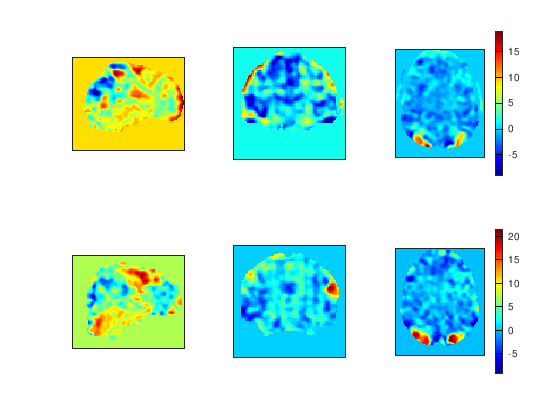

In [23]:
% Display contrast image

con_fn = spm_vol(fullfile(processing_dir, 'sub-01', 'stats', 'spmT_0001.nii'));
contrast = spm_read_vols(con_fn);
[Ni, Nj, Nk] = size(contrast);
subplot(231); imagesc(rot90(squeeze(contrast(round(Ni/2),:,:,1)))); colormap jet; axis image; set(gca,'xtick',[],'ytick',[]);
subplot(232); imagesc(rot90(squeeze(contrast(:,round(Nj/2),:,1)))); colormap jet; axis image; set(gca,'xtick',[],'ytick',[]);
subplot(233); imagesc(rot90(squeeze(contrast(:,:,round(Nk/2),1)))); colormap jet; colorbar; axis image; set(gca,'xtick',[],'ytick',[]);

con_fn = spm_vol(fullfile(processing_dir, 'sub-02', 'stats', 'spmT_0001.nii'));
contrast = spm_read_vols(con_fn);
[Ni, Nj, Nk] = size(contrast);
subplot(234); imagesc(rot90(squeeze(contrast(round(Ni/2),:,:,1)))); colormap jet; axis image; set(gca,'xtick',[],'ytick',[]);
subplot(235); imagesc(rot90(squeeze(contrast(:,round(Nj/2),:,1)))); colormap jet; axis image; set(gca,'xtick',[],'ytick',[]);
subplot(236); imagesc(rot90(squeeze(contrast(:,:,round(Nk/2),1)))); colormap jet; colorbar; axis image; set(gca,'xtick',[],'ytick',[]);

In [24]:
% Second level analysis (one sample t-test)
    
for i = 1:n_sub 
    if i < 10
        sub_path = '0%d';
        sub = sprintf(sub_path, i);
    else
        sub = i;
    end
    preproc_data(i).con1 = fullfile(processing_dir, ['sub-' sub], 'stats', 'con_0001.nii');
end

% Call script to set up design
spm_specify2ndlevel_ler(results_dir, preproc_data);



------------------------------------------------------------------------
24-Mar-2021 23:36:47 - Running job #1
------------------------------------------------------------------------
24-Mar-2021 23:36:47 - Running 'Factorial design specification'
Mapping files                           :                        ...done
Design configuration                    :                        ...done
Saving SPM configuration                :               ...SPM.mat saved
Completed                               :          23:36:48 - 24/03/2021
24-Mar-2021 23:36:48 - Done    'Factorial design specification'
24-Mar-2021 23:36:48 - Done



In [25]:
% Estimate second level analysis

spm_estimateModel_jsh(results_dir)



------------------------------------------------------------------------
24-Mar-2021 23:39:30 - Running job #1
------------------------------------------------------------------------
24-Mar-2021 23:39:30 - Running 'Model estimation'

SPM12: spm_spm (v7738)                             23:39:30 - 24/03/2021
Chunk   1/1                             :                  ...processi                       ...done
Spatial non-sphericity (over scans)     :      ...estimating derivativ ...writing resels/voxel ima                       ...done
Saving SPM.mat                          :                     ...writi                       ...done
Completed                               :          23:39:32 - 24/03/2021
Done
24-Mar-2021 23:39:32 - Done    'Model estimation'
24-Mar-2021 23:39:32 - Done



In [26]:
% Create contrast maps

contrast_params = struct;
contrast_params.weights = zeros(1); 
contrast_params.weights(1) = 1;
contrast_params.name = 'Positive';
spm_setupTaskContrast_jsh(results_dir, contrast_params)



------------------------------------------------------------------------
24-Mar-2021 23:39:55 - Running job #1
------------------------------------------------------------------------
24-Mar-2021 23:39:55 - Running 'Contrast Manager'

SPM12: spm_contrasts.m                             23:39:55 - 24/03/2021
Contrasts folder                        :           /home/jovyan/results
	contrast image  1               :                   ...computi       ...written con_0001.nii
	spm{T} image  1                 :                   ...computi      ...written spmT_0001.nii
	Saving SPM.mat                  :                     ...writi              ...SPM.mat saved
Completed                               :          23:39:55 - 24/03/2021
24-Mar-2021 23:39:55 - Done    'Contrast Manager'
24-Mar-2021 23:39:55 - Done



In [29]:
% Create thresholded maps (FWE, 0.05)

spm_runResults_jsh(results_dir, 'FWE', 0.05)



------------------------------------------------------------------------
24-Mar-2021 23:42:22 - Running job #1
------------------------------------------------------------------------
24-Mar-2021 23:42:23 - Running 'Results Report'
	SPM computation                 :                ...initialisi           ...height thresho           ...extent thresho                       ...done


Statistics: p-values adjusted for search volume
set	set	cluster	cluster	cluster	cluster	peak	peak	peak	peak	peak	
p	c	p(FWE-corr)	p(FDR-corr)	equivk	p(unc)	p(FWE-corr)	p(FDR-corr)	T	equivZ	p(unc)	x,y,z {mm}
--------------------------------------------------------------------------------
0.000	576	0.050	1.000	1	1.000	0.981	77.327	41369.12	 4.32	0.000	 42 -56   4 	
		0.050	1.000	1	1.000	0.981	77.161	41211.31	 4.32	0.000	-30  -2 -18 	
		0.050	1.000	1	1.000	0.933	52.924	28171.85	 4.24	0.000	-52  24   8 	
		0.050	1.000	1	1.000	0.926	50.904	27044.98	 4.23	0.000	 -6 -42  50 	
		0.050	1.000	3	1.000	0.768	28.707	151

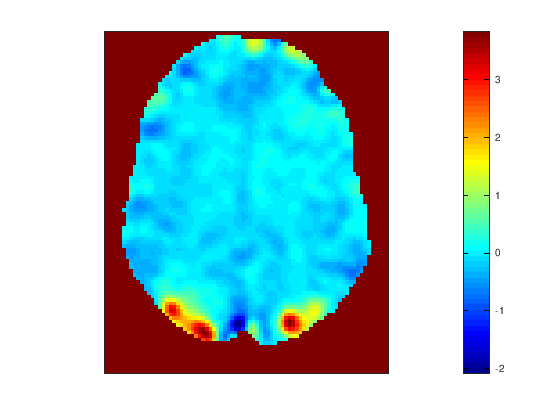

In [33]:
% Display group positive contrast

con_fn = spm_vol(fullfile(results_dir, 'con_0001.nii'));
contrast = spm_read_vols(con_fn);
[Ni, Nj, Nk] = size(contrast);
imagesc(rot90(squeeze(contrast(:,:,round(Nk/2))))); colormap jet; colorbar; axis image; set(gca,'xtick',[],'ytick',[]);

The code contained in this notebook is based on Stephan Heunis [tutorial](https://github.com/jsheunis/spm12-octave-jupyter).